In [ ]:
from google.colab import drive

drive.mount('./drive')

Mounted at ./drive


In [ ]:
from google.colab import files

files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kanseidorifto","key":"59a0c27f3b173df3276d8e2a799ccead"}'}

In [ ]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d devdgohil/the-oxfordiiit-pet-dataset

100% 780M/780M [00:08<00:00, 92.0MB/s]
100% 780M/780M [00:08<00:00, 95.6MB/s]


In [ ]:
!unzip -q the-oxfordiiit-pet-dataset.zip -d './oxford-pet'


In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Activation, Dropout, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers, applications
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from keras import backend as K

In [ ]:
or_dir = './oxford-pet/images/images'

In [ ]:
import os
import shutil

# Set the path to the dir containing all images
input_dir = or_dir

# Set the paths for the cat and dog dirs
cat_dir = './oxford-pet/images/cats'
dog_dir = './oxford-pet/images/dogs'

# Create the cat and dog dirs if they don't exist
os.makedirs(cat_dir, exist_ok=True)
os.makedirs(dog_dir, exist_ok=True)

# Loop through each file in the input dir
for filename in os.listdir(input_dir):
    # Check if the file is a cat image based on the capital letter
    if filename[0].isupper():  # Assuming cat images start with a capital letter
        src_path = os.path.join(input_dir, filename)
        dst_path = os.path.join(cat_dir, filename)
    else:
        src_path = os.path.join(input_dir, filename)
        dst_path = os.path.join(dog_dir, filename)

    # Move the file to the appropriate dir
    shutil.move(src_path, dst_path)

print("Dataset divided into cat and dog dirs.")


Dataset divided into cat and dog dirs.


In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Set the paths for the train, validation, and test dirss
cat_train_dir = './cats/cats_train'
cat_val_dir = './cats/cats_val'
cat_test_dir = './cats/cats_test'

dog_train_dir = './dogs/dogs_train'
dog_val_dir = './dogs/dogs_val'
dog_test_dir = './dogs/dogs_test'

# Function to create train, validation, and test dirs for a given class
def split_dataset(class_dir, train_dir, val_dir, test_dir, split_ratio=(0.7, 0.15, 0.15)):
    # Get the list of files in the class dir
    files = os.listdir(class_dir)

    # Split the files into train, validation, and test sets
    train_files, test_val_files = train_test_split(files, test_size=split_ratio[1] + split_ratio[2], random_state=42)
    val_files, test_files = train_test_split(test_val_files, test_size=split_ratio[2], random_state=42)

    # Create train, validation, and test dirs if they don't exist
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    # Move files to the respective dirs
    for filename in train_files:
        src_path = os.path.join(class_dir, filename)
        breed_name = '_'.join(filename.split('_')[:-1])  # Assuming the breed name is the first part of the filename
        dst_dir = os.path.join(train_dir, breed_name)
        os.makedirs(dst_dir, exist_ok=True)
        dst_path = os.path.join(dst_dir, filename)
        shutil.move(src_path, dst_path)

    for filename in val_files:
        src_path = os.path.join(class_dir, filename)
        breed_name = '_'.join(filename.split('_')[:-1])
        dst_dir = os.path.join(val_dir, breed_name)
        os.makedirs(dst_dir, exist_ok=True)
        dst_path = os.path.join(dst_dir, filename)
        shutil.move(src_path, dst_path)

    for filename in test_files:
        src_path = os.path.join(class_dir, filename)
        breed_name = '_'.join(filename.split('_')[:-1])
        dst_dir = os.path.join(test_dir, breed_name)
        os.makedirs(dst_dir, exist_ok=True)
        dst_path = os.path.join(dst_dir, filename)
        shutil.move(src_path, dst_path)

# Split the dataset for cats
split_dataset(cat_dir, cat_train_dir, cat_val_dir, cat_test_dir)

# Split the dataset for dogs
split_dataset(dog_dir, dog_train_dir, dog_val_dir, dog_test_dir)

print("Images divided into corresponding classes in train, validation, and test sets for cats and dogs.")


Images divided into corresponding classes in train, validation, and test sets for cats and dogs.


## КОТИКИ

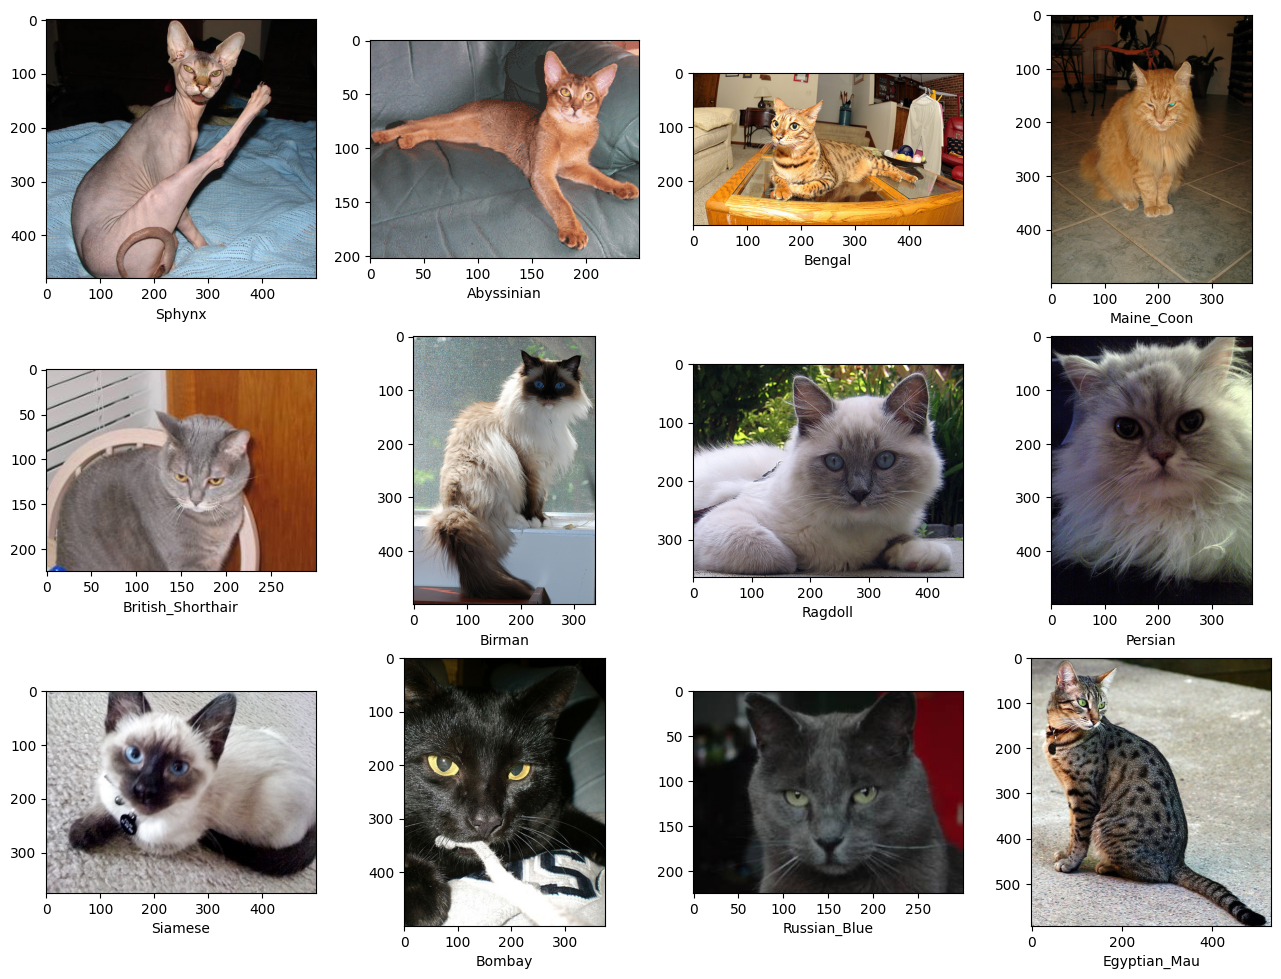

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

cat_files = []
for cat in os.listdir(cat_train_dir):
  cat_file_names = os.listdir(os.path.join(cat_train_dir, cat))
  cat_files.append(dict(label=cat, cat_file_paths= [os.path.join(cat_train_dir, cat, cat_file_name) for cat_file_name in cat_file_names]))


for i, cat in enumerate(cat_files):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  img = mpimg.imread(cat['cat_file_paths'][0])
  plt.imshow(img)
  plt.xlabel(cat['label'])

plt.show()

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models


In [ ]:
batch_size=25

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

traingen = ImageDataGenerator(preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
                             rotation_range=15,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range=0.1,
                             shear_range=0.1,
                             horizontal_flip=True,
                             fill_mode='nearest'
                             )

testgen = ImageDataGenerator(preprocessing_function = tf.keras.applications.efficientnet.preprocess_input)

valgen = ImageDataGenerator(preprocessing_function = tf.keras.applications.efficientnet.preprocess_input)

# Flow training images in batches
cat_train_generator = traingen.flow_from_directory(
        cat_train_dir,  # This is the source directory for training images
        target_size=(224, 224),  # All images will be resized to 224x224
        batch_size=batch_size,
        class_mode='categorical')
# Flow validating images in batches
cat_validation_generator = valgen.flow_from_directory(
        cat_val_dir,  # This is the source directory for validating images
        target_size=(224, 224),  # All images will be resized to 224x224
        batch_size=batch_size,
        class_mode='categorical')
# Flow test images in batches
cat_test_generator = testgen.flow_from_directory(
        cat_test_dir,  # This is the source directory for test images
        target_size=(224, 224),  # All images will be resized to 224x224
        batch_size=batch_size,
        class_mode='categorical')

Found 1680 images belonging to 12 classes.
Found 611 images belonging to 12 classes.
Found 109 images belonging to 12 classes.


In [ ]:
base_model =  tf.keras.applications.EfficientNetB3(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

43941136/43941136 [==============================] - 0s 0us/step


In [ ]:
# for layer in base_model.layers:
#     layer.trainable = False
base_model.trainable = False

In [ ]:
num_classes = len(set(cat_train_generator.classes))

cat_model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.35),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])

cat_model.compile(
    optimizer=tf.keras.optimizers.Adam(0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
cat_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 1536)              10783535  
 )                                                               
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 12)                3084      
                                                                 
Total params: 11181115 (42.65 MB)
Trainable params: 3970

In [ ]:
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

history = cat_model.fit(
    cat_train_generator,
    steps_per_epoch=len(cat_train_generator),
    validation_data=cat_validation_generator,
    validation_steps=len(cat_validation_generator),
    epochs=15,
    callbacks=[
        EarlyStopping(monitor = "val_loss",
                               patience = 5,
                               restore_best_weights = True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min')
    ]
)

Epoch 1/15
68/68 [==============================] - 55s 515ms/step - loss: 1.1238 - accuracy: 0.6429 - val_loss: 0.5260 - val_accuracy: 0.8167 - lr: 5.0000e-04
Epoch 2/15
68/68 [==============================] - 36s 534ms/step - loss: 0.4958 - accuracy: 0.8292 - val_loss: 0.3696 - val_accuracy: 0.8592 - lr: 5.0000e-04
Epoch 3/15
68/68 [==============================] - 28s 407ms/step - loss: 0.3715 - accuracy: 0.8762 - val_loss: 0.3562 - val_accuracy: 0.8789 - lr: 5.0000e-04
Epoch 4/15
68/68 [==============================] - 30s 433ms/step - loss: 0.3070 - accuracy: 0.8905 - val_loss: 0.3143 - val_accuracy: 0.8936 - lr: 5.0000e-04
Epoch 5/15
68/68 [==============================] - 31s 449ms/step - loss: 0.2622 - accuracy: 0.9155 - val_loss: 0.3277 - val_accuracy: 0.8953 - lr: 5.0000e-04
Epoch 6/15
68/68 [==============================] - 29s 426ms/step - loss: 0.2306 - accuracy: 0.9202 - val_loss: 0.3396 - val_accuracy: 0.8887 - lr: 5.0000e-04
Epoch 7/15
68/68 [======================

Text(0, 0.5, 'Loss')

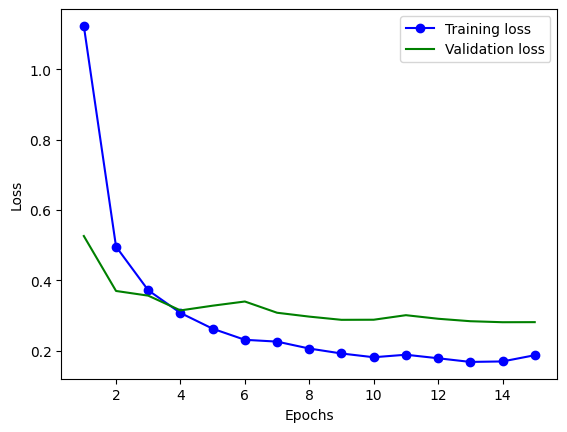

In [ ]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'bo-', label='Training loss')
plt.plot(epochs, val_loss_values, 'g', label='Validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')


Text(0, 0.5, 'Accuracy')

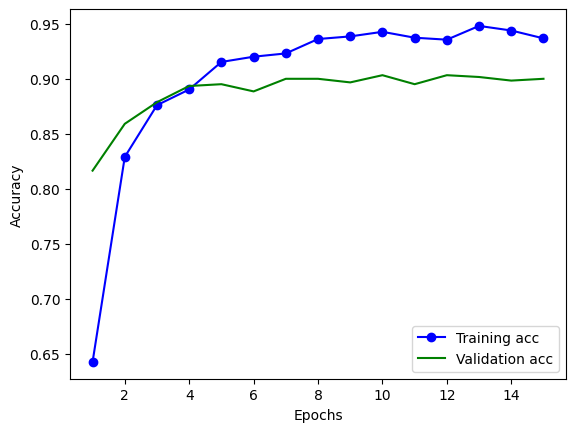

In [ ]:
history_dict = history.history
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values) + 1)
plt.plot(epochs, acc_values, 'bo-', label='Training acc')
plt.plot(epochs, val_acc_values, 'g', label='Validation acc')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')


### Оцінка точності навчання

In [ ]:
scores = cat_model.evaluate(cat_test_generator, batch_size = batch_size)

5/5 [==============================] - 1s 244ms/step - loss: 0.2079 - accuracy: 0.9266


In [ ]:
print("Доля правильних відповідей на тестових даних, у відсотках:", round(scores[1] * 100, 4))

Доля правильних відповідей на тестових даних, у відсотках: 92.6606


## Fine tuning

In [ ]:
base_model.trainable = True
for layer in base_model.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False

cat_model.compile(
    optimizer=tf.keras.optimizers.Adam(0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(cat_model.summary())
history = cat_model.fit(
    cat_train_generator,
    steps_per_epoch=len(cat_train_generator),
    validation_data=cat_validation_generator,
    validation_steps=len(cat_validation_generator),
    epochs=15,
    callbacks=[
        EarlyStopping(monitor = "val_loss",
                               patience = 3,
                               restore_best_weights = True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min')
    ]
)

input_1 True
rescaling True
normalization True
rescaling_1 True
stem_conv_pad True
stem_conv True
stem_bn False
stem_activation True
block1a_dwconv True
block1a_bn False
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 1536)              10783535  
 )                                                               
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)  

Text(0, 0.5, 'Loss')

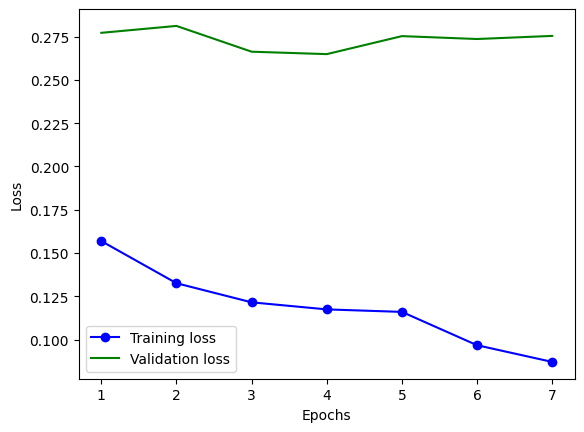

In [ ]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'bo-', label='Training loss')
plt.plot(epochs, val_loss_values, 'g', label='Validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')


Text(0, 0.5, 'Accuracy')

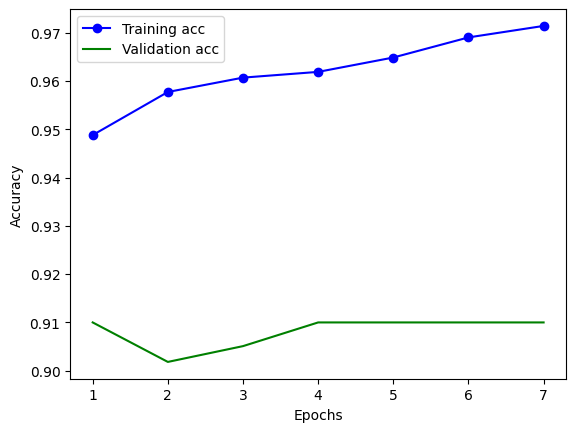

In [ ]:
history_dict = history.history
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values) + 1)
plt.plot(epochs, acc_values, 'bo-', label='Training acc')
plt.plot(epochs, val_acc_values, 'g', label='Validation acc')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')


### Оцінка точності навчання

In [ ]:
scores = cat_model.evaluate(cat_test_generator, batch_size = batch_size)

5/5 [==============================] - 1s 102ms/step - loss: 0.1621 - accuracy: 0.9266


In [ ]:
print("Доля правильних відповідей на тестових даних, після донавчання, у відсотках:", round(scores[1] * 100, 4))

Доля правильних відповідей на тестових даних, після донавчання, у відсотках: 92.6606


### Перевірка прогнозування на зображеннях котиків

In [ ]:
import numpy as np
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array
import matplotlib.pyplot as plt

uploaded = files.upload()

Saving Bengal-Cat.jpeg to Bengal-Cat.jpeg
Saving birman.jpg to birman.jpg
Saving bombay.png to bombay.png
Saving british-shorthair.png to british-shorthair.png
Saving mainecoon.jpg to mainecoon.jpg
Saving sphynx.png to sphynx.png


1/1 [==============================] - 0s 31ms/step


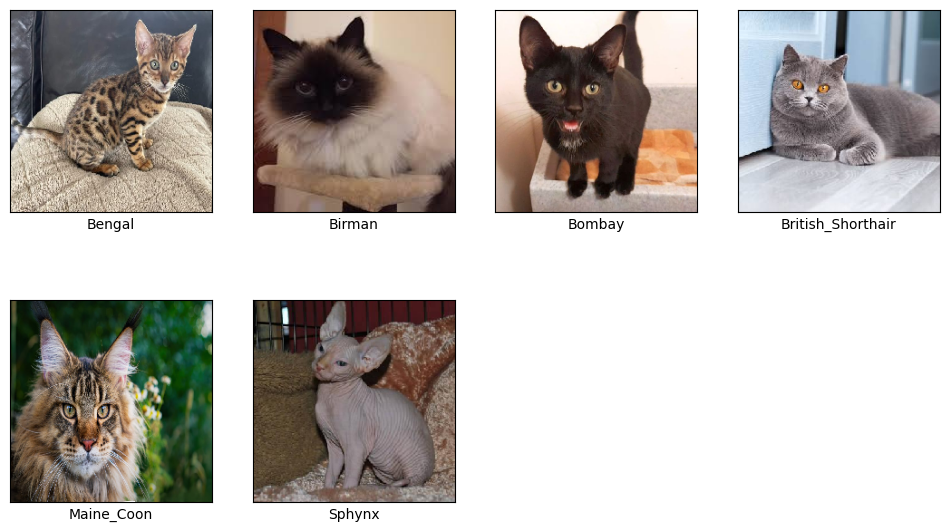

In [ ]:
cat_classes = list(cat_train_generator.class_indices)

plt.figure(figsize=(12,22))
for i, fn in enumerate(uploaded.keys()):
  path = '/content/' + fn
  img = load_img(path, target_size=(224, 224))
  x = img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = tf.keras.applications.mobilenet_v3.preprocess_input(x)
  preds = cat_model.predict(x)
  predicted_class = np.argmax(preds[0])
  plt.subplot(6,4,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(img)
  plt.xlabel(cat_classes[predicted_class])

### Збереження моделі для розпізнавання та списку порід котиків

In [ ]:
cat_model.save('./cat_breed_recognition_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import pickle

with open('./cat_breed_list.pkl', mode='wb') as cat_list_file:
  pickle.dump(cat_classes, cat_list_file)

In [ ]:
!cp ./cat_breed_recognition_model.h5 ./drive/MyDrive/4Course
!cp ./cat_breed_list.pkl ./drive/MyDrive/4Course

## ПЕСИКИ

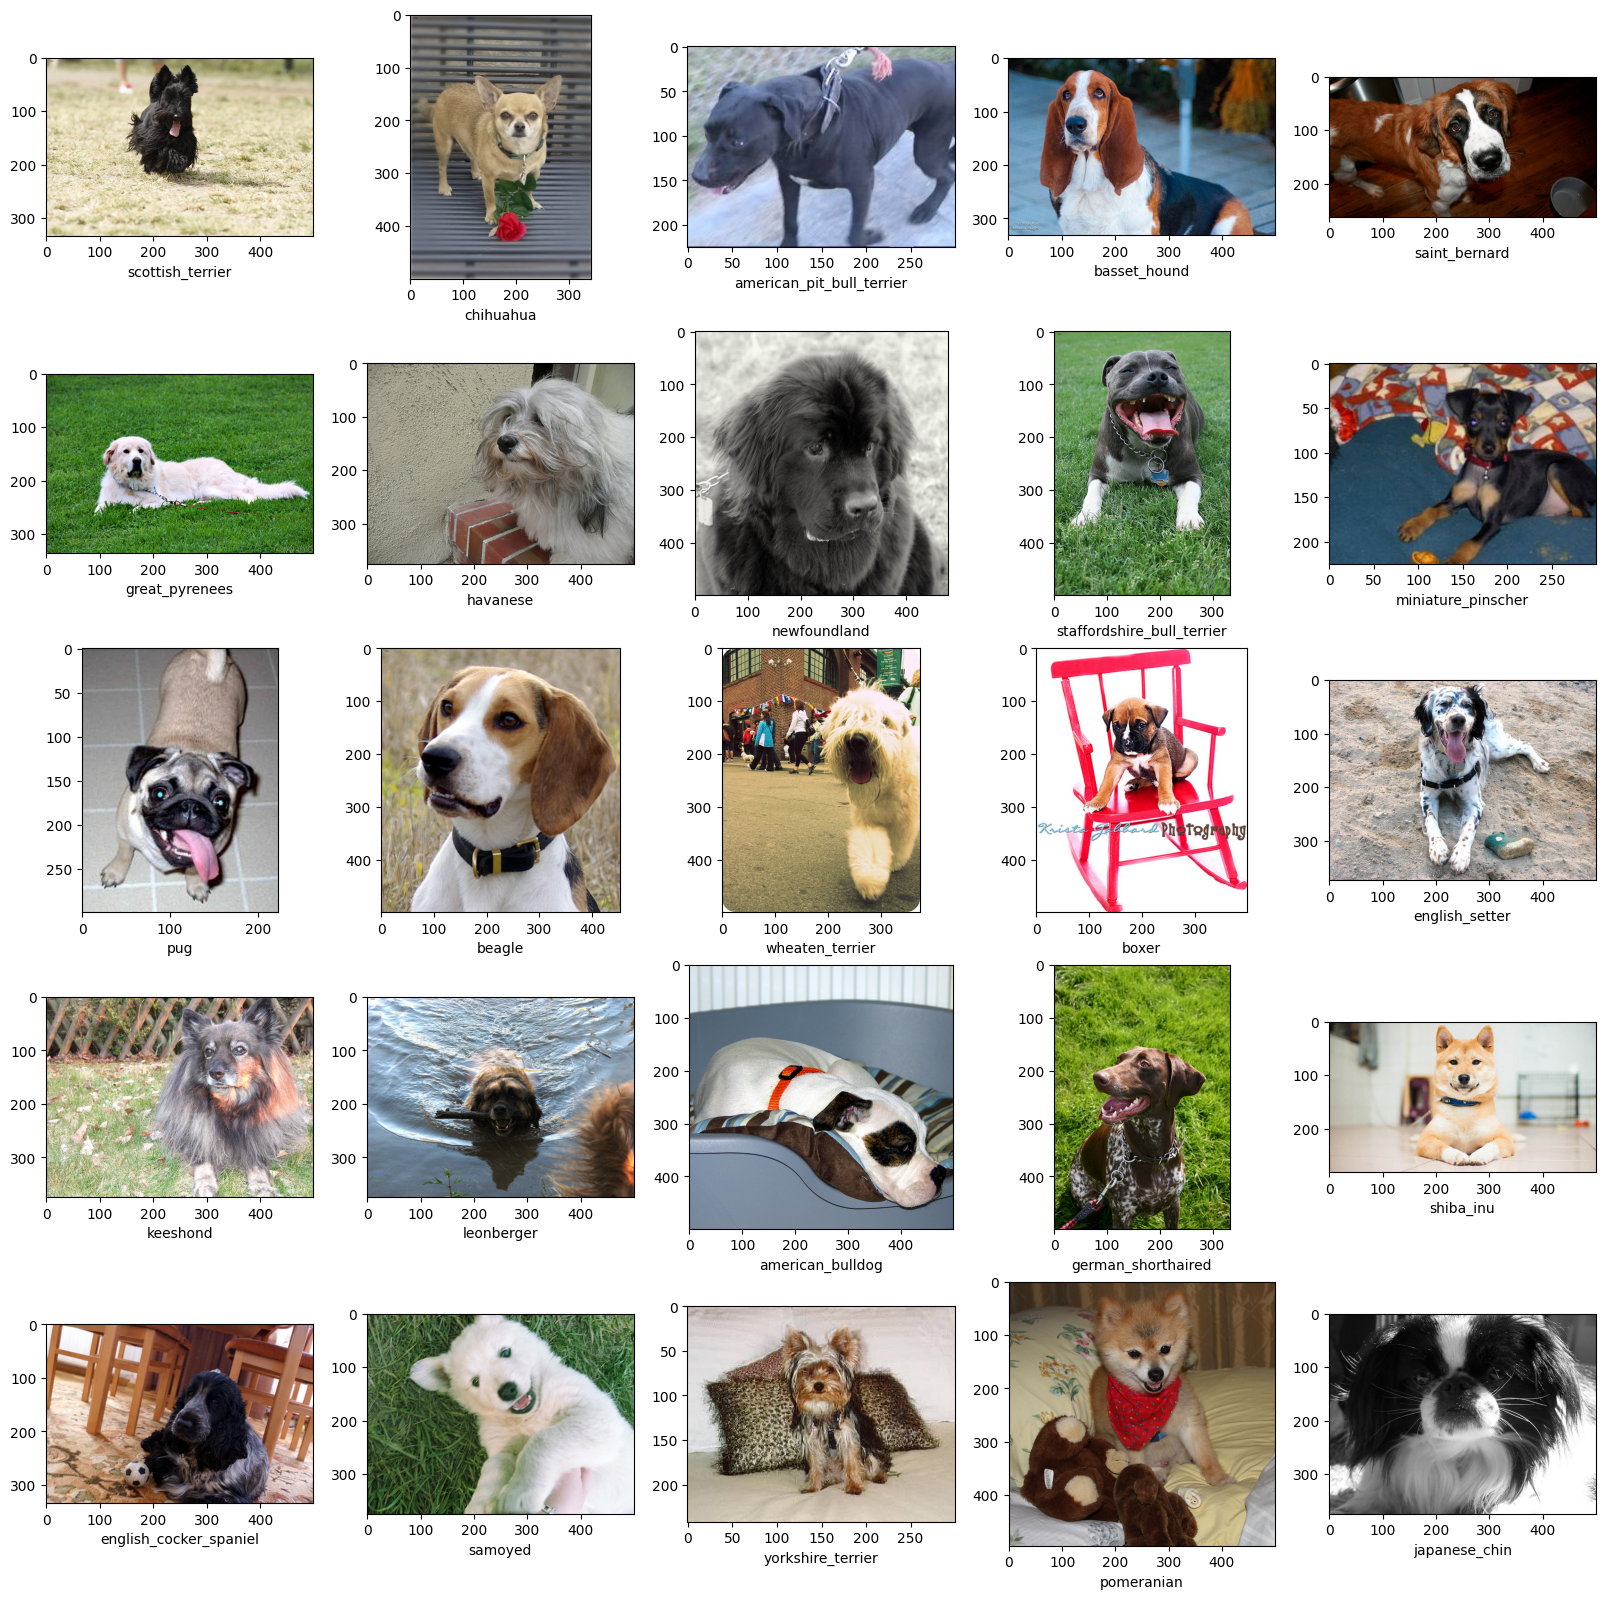

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 6
ncols = 5

# Index for iterating over images
pic_index = 0
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

dog_files = []
for dog in os.listdir(dog_train_dir):
  dog_file_names = os.listdir(os.path.join(dog_train_dir, dog))
  dog_files.append(dict(label=dog, dog_file_paths= [os.path.join(dog_train_dir, dog, dog_file_name) for dog_file_name in dog_file_names]))


for i, dog in enumerate(dog_files):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  img = mpimg.imread(dog['dog_file_paths'][0])
  plt.imshow(img)
  plt.xlabel(dog['label'])

plt.show()

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models


In [ ]:
batch_size=25

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

traingen = ImageDataGenerator(preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
                             rotation_range=15,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range=0.1,
                             shear_range=0.1,
                             horizontal_flip=True,
                             fill_mode='nearest'
                             )

testgen = ImageDataGenerator(preprocessing_function = tf.keras.applications.efficientnet.preprocess_input)

valgen = ImageDataGenerator(preprocessing_function = tf.keras.applications.efficientnet.preprocess_input)

# Flow training images in batches
dog_train_generator = traingen.flow_from_directory(
        dog_train_dir,  # This is the source directory for training images
        target_size=(224, 224),  # All images will be resized to 224x224
        batch_size=batch_size,
        class_mode='categorical')
# Flow validating images in batches
dog_validation_generator = valgen.flow_from_directory(
        dog_val_dir,  # This is the source directory for validating images
        target_size=(224, 224),  # All images will be resized to 224x224
        batch_size=batch_size,
        class_mode='categorical')
# Flow test images in batches
dog_test_generator = testgen.flow_from_directory(
        dog_test_dir,  # This is the source directory for test images
        target_size=(224, 224),  # All images will be resized to 224x224
        batch_size=batch_size,
        class_mode='categorical')

Found 3493 images belonging to 25 classes.
Found 1272 images belonging to 25 classes.
Found 225 images belonging to 25 classes.


In [ ]:
dog_base_model =  tf.keras.applications.EfficientNetB3(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

In [ ]:
dog_base_model.trainable = False

In [ ]:
num_classes = len(set(dog_train_generator.classes))

dog_model = tf.keras.Sequential([
  dog_base_model,
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.45),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])

dog_model.compile(
    optimizer=tf.keras.optimizers.Adam(0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
dog_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 1536)              10783535  
 )                                                               
                                                                 
 dense_4 (Dense)             (None, 256)               393472    
                                                                 
 batch_normalization_2 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 25)                6425      
                                                                 
Total params: 11184456 (42.67 MB)
Trainable params: 40

In [ ]:
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

history = dog_model.fit(
    dog_train_generator,
    steps_per_epoch=len(dog_train_generator),
    validation_data=dog_validation_generator,
    validation_steps=len(dog_validation_generator),
    epochs=15,
    callbacks=[
        EarlyStopping(monitor = "val_loss",
                               patience = 3,
                               restore_best_weights = True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min')
    ]
)

Epoch 1/15
140/140 [==============================] - 81s 493ms/step - loss: 0.7457 - accuracy: 0.7933 - val_loss: 0.2294 - val_accuracy: 0.9269 - lr: 5.0000e-04
Epoch 2/15
140/140 [==============================] - 65s 468ms/step - loss: 0.2711 - accuracy: 0.9147 - val_loss: 0.1749 - val_accuracy: 0.9410 - lr: 5.0000e-04
Epoch 3/15
140/140 [==============================] - 63s 447ms/step - loss: 0.2114 - accuracy: 0.9322 - val_loss: 0.1830 - val_accuracy: 0.9426 - lr: 5.0000e-04
Epoch 4/15
140/140 [==============================] - 62s 445ms/step - loss: 0.1734 - accuracy: 0.9470 - val_loss: 0.1833 - val_accuracy: 0.9434 - lr: 5.0000e-04
Epoch 5/15
140/140 [==============================] - 62s 441ms/step - loss: 0.1351 - accuracy: 0.9545 - val_loss: 0.1550 - val_accuracy: 0.9520 - lr: 1.0000e-04
Epoch 6/15
140/140 [==============================] - 65s 464ms/step - loss: 0.1282 - accuracy: 0.9631 - val_loss: 0.1535 - val_accuracy: 0.9489 - lr: 1.0000e-04
Epoch 7/15
140/140 [========

Text(0, 0.5, 'Loss')

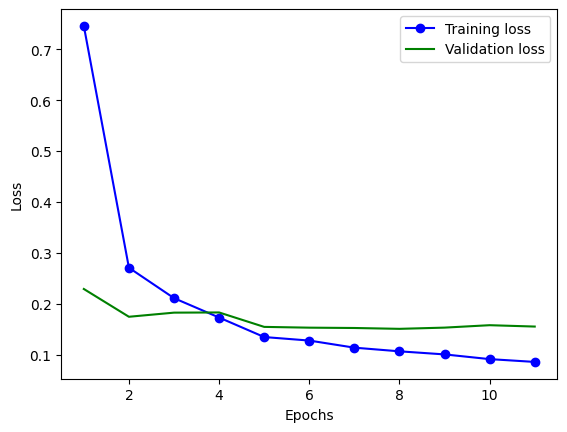

In [ ]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'bo-', label='Training loss')
plt.plot(epochs, val_loss_values, 'g', label='Validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')


Text(0, 0.5, 'Accuracy')

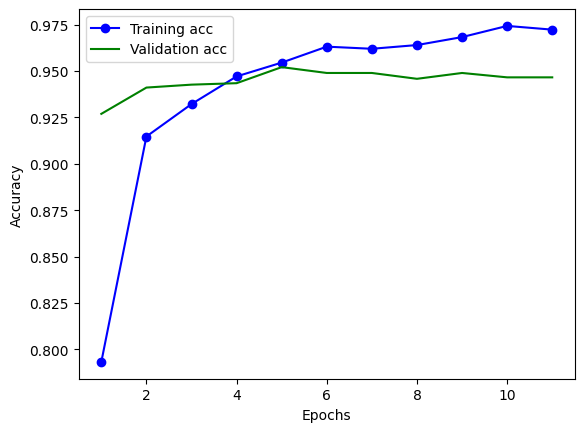

In [ ]:
history_dict = history.history
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values) + 1)
plt.plot(epochs, acc_values, 'bo-', label='Training acc')
plt.plot(epochs, val_acc_values, 'g', label='Validation acc')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')


### Оцінка точності навчання

In [ ]:
scores = dog_model.evaluate(dog_test_generator, batch_size = batch_size)

9/9 [==============================] - 2s 149ms/step - loss: 0.1537 - accuracy: 0.9511


In [ ]:
print("Доля правильних відповідей на тестових даних, у відсотках:", round(scores[1] * 100, 4))

Доля правильних відповідей на тестових даних, у відсотках: 95.1111


### Fine tuning

In [ ]:
base_model.trainable = True
for layer in base_model.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False

cat_model.compile(
    optimizer=tf.keras.optimizers.Adam(0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(cat_model.summary())
history = cat_model.fit(
    cat_train_generator,
    steps_per_epoch=len(cat_train_generator),
    validation_data=cat_validation_generator,
    validation_steps=len(cat_validation_generator),
    epochs=15,
    callbacks=[
        EarlyStopping(monitor = "val_loss",
                               patience = 3,
                               restore_best_weights = True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min')
    ]
)

input_1 True
rescaling True
normalization True
rescaling_1 True
stem_conv_pad True
stem_conv True
stem_bn False
stem_activation True
block1a_dwconv True
block1a_bn False
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 1536)              10783535  
 )                                                               
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)  

Text(0, 0.5, 'Loss')

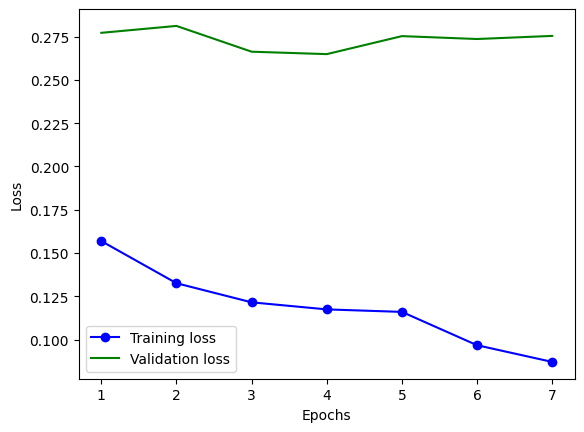

In [ ]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'bo-', label='Training loss')
plt.plot(epochs, val_loss_values, 'g', label='Validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')


Text(0, 0.5, 'Accuracy')

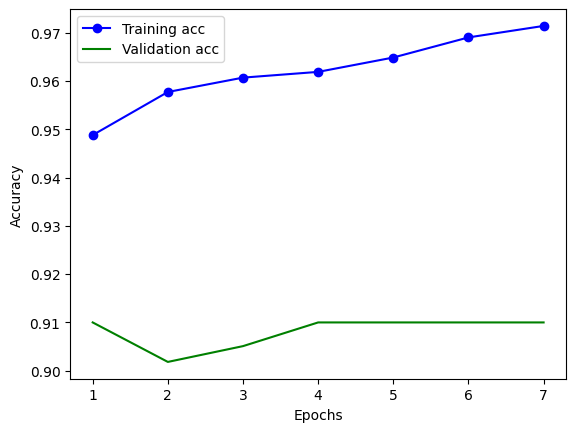

In [ ]:
history_dict = history.history
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values) + 1)
plt.plot(epochs, acc_values, 'bo-', label='Training acc')
plt.plot(epochs, val_acc_values, 'g', label='Validation acc')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')


### Оцінка точності навчання

In [ ]:
scores = dog_model.evaluate(dog_test_generator, batch_size = batch_size)

5/5 [==============================] - 1s 102ms/step - loss: 0.1621 - accuracy: 0.9266


In [ ]:
print("Доля правильних відповідей на тестових даних, після донавчання, у відсотках:", round(scores[1] * 100, 4))

Доля правильних відповідей на тестових даних, після донавчання, у відсотках: 92.6606


### Перевірка прогнозування на зображеннях собак

In [ ]:
import numpy as np
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array
import matplotlib.pyplot as plt

uploaded = files.upload()

Saving american-bulldog.png to american-bulldog.png
Saving boxer.png to boxer.png
Saving chihuahua.png to chihuahua.png
Saving german-shorthair.png to german-shorthair.png
Saving havanese.png to havanese.png
Saving japanese-chin.png to japanese-chin.png
Saving pomeranian.png to pomeranian.png
Saving pug.png to pug.png
Saving samoyed.png to samoyed.png
Saving shiba-inu.png to shiba-inu.png


1/1 [==============================] - 0s 34ms/step


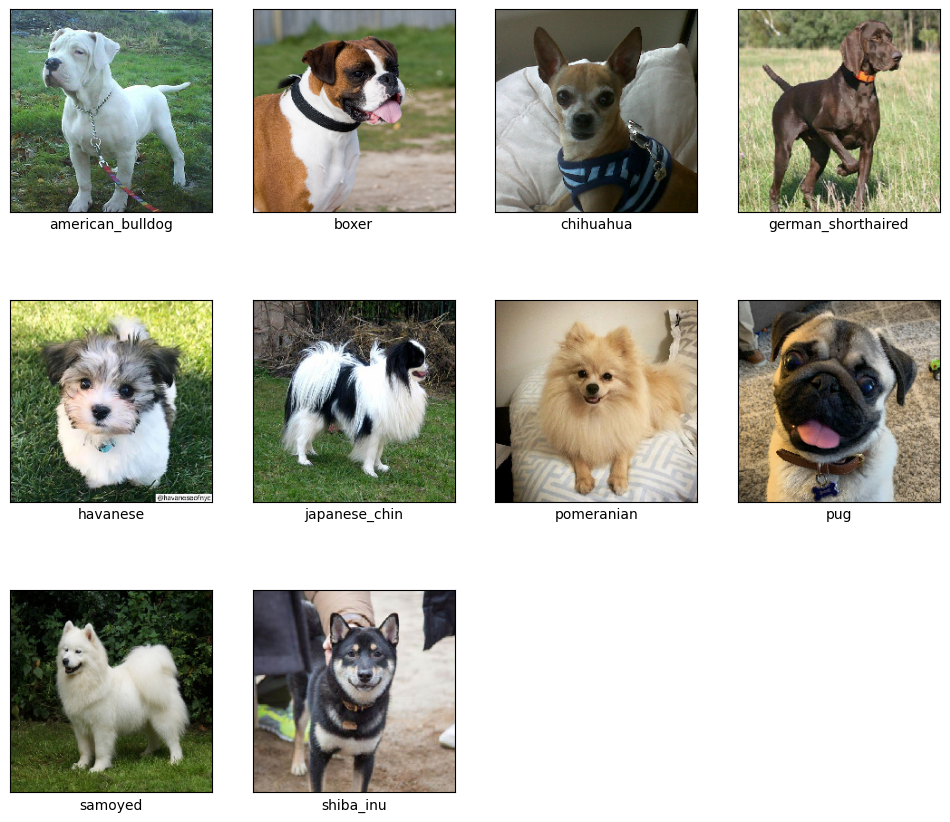

In [ ]:
dog_classes = list(dog_train_generator.class_indices)

plt.figure(figsize=(12,22))
for i, fn in enumerate(uploaded.keys()):
  path = '/content/' + fn
  img = load_img(path, target_size=(224, 224))
  x = img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = tf.keras.applications.mobilenet_v3.preprocess_input(x)
  preds = dog_model.predict(x)
  predicted_class = np.argmax(preds[0])
  plt.subplot(6,4,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(img)
  plt.xlabel(dog_classes[predicted_class])

### Збереження моделі для розпізнавання та списку порід собак

In [ ]:
dog_model.save('./dog_breed_recognition_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import pickle

with open('./dog_breed_list.pkl', mode='wb') as dog_list_file:
  pickle.dump(dog_classes, dog_list_file)

In [ ]:
!cp ./dog_breed_recognition_model.h5 ./drive/MyDrive/4Course
!cp ./dog_breed_list.pkl ./drive/MyDrive/4Course